__TODO : FIX BUG__
- [x] Currently the code for constructing the synthetic spectra computes blocks of 1000 instead of 5000!
- [x] Re-run to include the other blocks once they finish running on NERSC

Recently I updated the GAMA-Legacy catalog to incorporate the latest Legacy DR7. A significant number of new galaxies are included in this catalog. Along with the GLeg catalog I've also updated the synethic spectra and re-ran them through redrock. In this notebook, I will examine and output the targets that `redrock` fails to recover correct redshift. 

Throughout the notebook I will consider redrock failures as objects with: 

($\frac{|z_\mathrm{redrock} - z_\mathrm{true}|}{(1.+z_\mathrm{true})} < 0.003$) and ZWARN = 0 

In [1]:
import h5py 
import numpy as np 
from astropy.io import fits
# -- feasibgs -- 
from feasibgs import util as UT
from feasibgs import catalogs as Cat
from feasibgs import forwardmodel as FM

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
# read in GAMA-Legacy catalog
cata = Cat.GamaLegacy()
gleg = cata.Read('g15')

In [4]:
# select properties from the GAMA-Legacy catalog
redshift = gleg['gama-spec']['z']
# apparent magnitudes from Legacy photometry
g_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_g'])#, method='log')
r_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_r'])#, method='log')
# H-alpha line flux from GAMA spectroscopy
gama_ha = gleg['gama-spec']['ha_flux']

# absolute magnitude calculated using GAMA photometry
absmag_ugriz = cata.AbsMag(gleg, kcorr=0.1, H0=70, Om0=0.3)
g_absmag_gama = absmag_ugriz[1,:]
r_absmag_gama = absmag_ugriz[2,:]
ngal = len(redshift)
print('%i galaxies total' % ngal)

63495 galaxies total


In [5]:
def redrock_fail(iblock, nblock=13): 
    dir_spec = UT.dat_dir()+'spectra/gamadr3_legacydr7/'
    # read in gleg data
    fblock = h5py.File(dir_spec+'gleg.g15.darksky.seed1.exptime300.'+str(iblock)+'of'+str(nblock)+'blocks.hdf5', 'r')
    block = {}
    for g in fblock.keys():
        block[g] = {} 
        for k in fblock[g].keys(): 
            block[g][k] = fblock[g][k].value
    # read in redrock output 
    zblock = fits.open(dir_spec+'g15.synSpectra.darksky.seed1.exptime300.'+str(iblock)+'of'+str(nblock)+'blocks.redrock.fits')[1].data

    z_true = block['gama-spec']['z']
    z_rr = zblock['Z']
    dz_1pz = np.abs(z_true - z_rr)/(1.+z_true)

    zwarn = zblock['ZWARN']
    fail = (dz_1pz > 0.003) & (zwarn == 0)
    print('redrock fails for %i out of %i targets' % (np.sum(fail), len(z_rr)))

    # write out fail galaxies
    ffail = dir_spec+'gleg.g15.darksky.seed1.exptime300.'+str(iblock)+'of'+str(nblock)+'blocks.redrock_fail.hdf5'
    fail_block = {} 
    for g in block.keys(): 
        fail_block[g] = {}
        for k in block[g].keys():
            fail_block[g][k] = block[g][k][fail]
    cata.write(fail_block, ffail)
    return block, fail_block

redrock fails for 105 out of 5000 targets
redrock fails for 99 out of 5000 targets
redrock fails for 117 out of 5000 targets
redrock fails for 93 out of 5000 targets
redrock fails for 59 out of 5000 targets
redrock fails for 50 out of 5000 targets
redrock fails for 53 out of 5000 targets
redrock fails for 50 out of 5000 targets
redrock fails for 63 out of 5000 targets
redrock fails for 73 out of 5000 targets
redrock fails for 84 out of 5000 targets
redrock fails for 51 out of 5000 targets
redrock fails for 38 out of 3495 targets


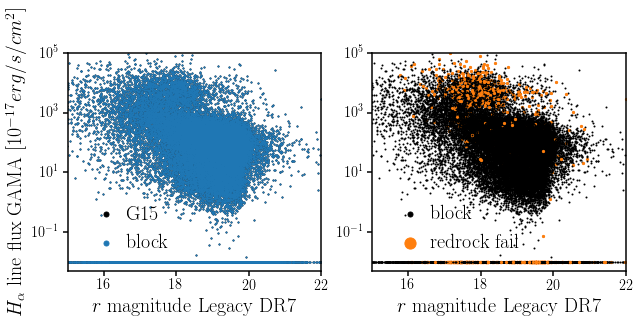

In [6]:
fig = plt.figure(figsize=(10, 4))
sub = fig.add_subplot(121)
sub2 = fig.add_subplot(122)
# entire G15 field
hasha = (gama_ha > 0)
sub.scatter(r_mag_legacy[hasha], gama_ha[hasha], s=1, c='k', label='G15')
sub.scatter(r_mag_legacy[~hasha], np.repeat(1e-2, np.sum(~hasha)), s=1, c='k')

for i in range(1,14):
    block, fail_block = redrock_fail(i)
    # block
    block_ha = block['gama-spec']['ha_flux']
    block_r_mag = UT.flux2mag(block['legacy-photo']['flux_r'])
    hasha = (block_ha > 0.)
    sub.scatter(block_r_mag[hasha], block_ha[hasha], s=1, c='C0', label='block')
    sub.scatter(block_r_mag[~hasha], np.repeat(1e-2, np.sum(~hasha)), s=1, c='C0')

    sub2.scatter(block_r_mag[hasha], block_ha[hasha], s=1, c='k', label='block')
    sub2.scatter(block_r_mag[~hasha], np.repeat(1e-2, np.sum(~hasha)), s=1, c='k')

    # redrock fails
    block_ha = fail_block['gama-spec']['ha_flux']
    block_r_mag = UT.flux2mag(fail_block['legacy-photo']['flux_r'])
    hasha = (block_ha > 0.)
    sub2.scatter(block_r_mag[hasha], block_ha[hasha], s=5, c='C1', label='redrock fail')
    sub2.scatter(block_r_mag[~hasha], np.repeat(1e-2, np.sum(~hasha)), s=5, c='C1')

    if i == 1: 
        sub.legend(loc='lower left', markerscale=5, handletextpad=0., fontsize=20)
        sub2.legend(loc='lower left', markerscale=5, handletextpad=0., fontsize=20)

sub.set_xlabel(r'$r$ magnitude Legacy DR7', fontsize=20)
sub.set_xlim([15., 22.])
sub.set_ylabel(r'$H_\alpha$ line flux GAMA $[10^{-17}erg/s/cm^2]$', fontsize=20)
sub.set_ylim([5e-3, 1e5])
sub.set_yscale('log')

sub2.set_xlabel(r'$r$ magnitude Legacy DR7', fontsize=20)
sub2.set_xlim([15., 22.])
sub2.set_ylim([5e-3, 1e5])
sub2.set_yscale('log')

Figure above reveals that for a significant number of spectra with $r < 20$ and strong H$\alpha$ emission lines, redrock fails to recove the true redshift!

redrock fails for 105 out of 5000 targets
redrock fails for 99 out of 5000 targets
redrock fails for 117 out of 5000 targets
redrock fails for 93 out of 5000 targets
redrock fails for 59 out of 5000 targets
redrock fails for 50 out of 5000 targets
redrock fails for 53 out of 5000 targets
redrock fails for 50 out of 5000 targets
redrock fails for 63 out of 5000 targets
redrock fails for 73 out of 5000 targets
redrock fails for 84 out of 5000 targets
redrock fails for 51 out of 5000 targets
redrock fails for 38 out of 3495 targets
935


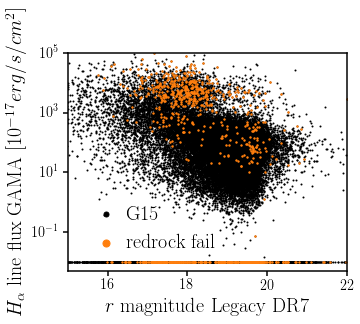

In [7]:
fig = plt.figure(figsize=(5, 4))
sub = fig.add_subplot(111)
# entire G15 field
hasha = (gama_ha > 0)
sub.scatter(r_mag_legacy[hasha], gama_ha[hasha], s=1, c='k', label='G15')
sub.scatter(r_mag_legacy[~hasha], np.repeat(1e-2, np.sum(~hasha)), s=1, c='k')

fails_ha, fails_r_mag = [], []
for i in range(1,14):
    block, fail_block = redrock_fail(i)
    # redrock fails for each block
    fails_ha.append(fail_block['gama-spec']['ha_flux'])
    fails_r_mag.append(UT.flux2mag(fail_block['legacy-photo']['flux_r']))

fails_ha = np.concatenate(fails_ha)
fails_r_mag = np.concatenate(fails_r_mag)

print len(fails_ha)
hasha = (fails_ha > 0.)
sub.scatter(fails_r_mag[hasha], fails_ha[hasha], s=2, c='C1', label='redrock fail')
sub.scatter(fails_r_mag[~hasha], np.repeat(1e-2, np.sum(~hasha)), s=2, c='C1')
sub.legend(loc='lower left', markerscale=5, handletextpad=0., fontsize=20)
sub.set_xlabel(r'$r$ magnitude Legacy DR7', fontsize=20)
sub.set_xlim([15., 22.])
sub.set_ylabel(r'$H_\alpha$ line flux GAMA $[10^{-17}erg/s/cm^2]$', fontsize=20)
sub.set_ylim([5e-3, 1e5])
sub.set_yscale('log')

(15.0, 22.0)

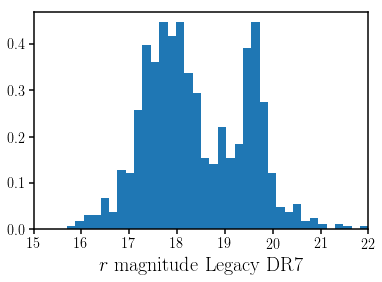

In [8]:
fig = plt.figure()
sub = fig.add_subplot(111)
_ = sub.hist(fails_r_mag, range=(15, 22), bins=40, density=True)
sub.set_xlabel(r'$r$ magnitude Legacy DR7', fontsize=20)
sub.set_xlim([15., 22.])

0.6


(-3.0, 5.0)

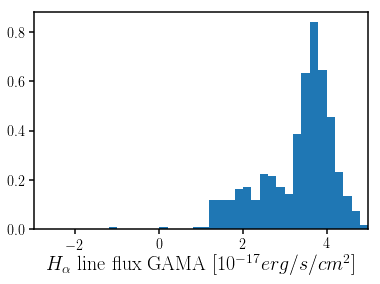

In [9]:
print float(np.sum(hasha))/float(len(hasha))
fig = plt.figure()
sub = fig.add_subplot(111)
_ = sub.hist(np.log10(fails_ha[hasha]), range=(-3, 5), bins=40, density=True)
sub.set_xlabel(r'$H_\alpha$ line flux GAMA $[10^{-17}erg/s/cm^2]$', fontsize=20)
sub.set_xlim([-3., 5.])

In [25]:
blocks_ztrue, blocks_z_rr, blocks_zwarn = [], [], [] 
blocks_ha, blocks_r_mag, blocks_magnorm = [], [], []
for i in range(1,14):
    block, _ = redrock_fail(i)
    # redrock fails for each block
    block_ha = block['gama-spec']['ha_flux']
    block_r_mag = UT.flux2mag(block['legacy-photo']['flux_r'])
    block_ztrue = block['gama-spec']['z']
    
    # read in redrock output 
    dir_spec = UT.dat_dir()+'spectra/gamadr3_legacydr7/'
    zblock = fits.open(dir_spec+'g15.synSpectra.darksky.seed1.exptime300.'+str(i)+'of13blocks.redrock.fits')[1].data
    
    blocks_ha.append(block_ha)
    blocks_r_mag.append(block_r_mag)
    blocks_ztrue.append(block_ztrue)
    blocks_z_rr.append(zblock['Z'])
    blocks_zwarn.append(zblock['ZWARN'])
    blocks_magnorm.append(block['forwardmodel']['magnorm_flag'])

blocks_ha = np.concatenate(blocks_ha)
blocks_r_mag = np.concatenate(blocks_r_mag)
blocks_ztrue = np.concatenate(blocks_ztrue)
blocks_z_rr = np.concatenate(blocks_z_rr)
blocks_zwarn = np.concatenate(blocks_zwarn)
blocks_magnorm = np.concatenate(blocks_magnorm)

redrock fails for 105 out of 5000 targets
redrock fails for 99 out of 5000 targets
redrock fails for 117 out of 5000 targets
redrock fails for 93 out of 5000 targets
redrock fails for 59 out of 5000 targets
redrock fails for 50 out of 5000 targets
redrock fails for 53 out of 5000 targets
redrock fails for 50 out of 5000 targets
redrock fails for 63 out of 5000 targets
redrock fails for 73 out of 5000 targets
redrock fails for 84 out of 5000 targets
redrock fails for 51 out of 5000 targets
redrock fails for 38 out of 3495 targets


In [11]:
def zsuccess_rate(prop, zsuccess_cond, range=None, nbins=20, bin_min=2):
    """ 
    """
    h0, bins = np.histogram(prop, bins=nbins, range=range)
    hv, _ = np.histogram(prop, bins=bins, weights=prop)
    h1, _ = np.histogram(prop[zsuccess_cond], bins=bins)
    
    good = h0 > bin_min
    hv = hv[good]
    h0 = h0[good]
    h1 = h1[good]

    vv = hv / h0 # weighted mean of var
    
    def _eff(k, n):
        eff = k.astype("float") / (n.astype('float') + (n==0))
        efferr = np.sqrt(eff * (1 - eff)) / np.sqrt(n.astype('float') + (n == 0))
        return eff, efferr
    
    e1, ee1 = _eff(h1, h0)
    return vv, e1, ee1

In [12]:
success = ((np.abs(blocks_ztrue - blocks_z_rr)/(1. + blocks_ztrue) < 0.003) & (blocks_zwarn == 0))

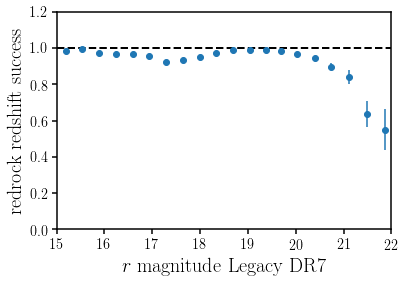

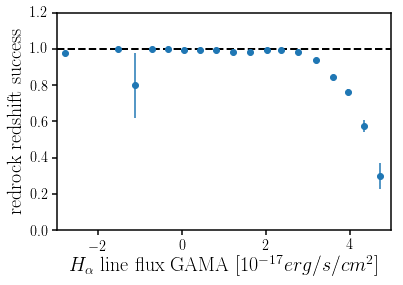

In [35]:
mm, e1, ee1 = zsuccess_rate(blocks_r_mag, success, range=[15., 22.])

fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot([15., 22.], [1., 1.], c='k', ls='--', lw=2)
sub.errorbar(mm, e1, ee1, c='C0', fmt='o')
#sub.errorbar(mm_bright, e1_bright, ee1_bright, fmt='.C1', label="bright sky")
sub.set_xlabel(r'$r$ magnitude Legacy DR7', fontsize=20)
sub.set_xlim([15., 22.])
sub.set_ylabel(r'redrock redshift success', fontsize=20)
sub.set_ylim([0., 1.2])
sub.legend(loc='lower right', handletextpad=0., prop={'size': 20})

hasha = (blocks_ha > 0.)

blocks_ha_lowlim = blocks_ha.copy()
blocks_ha_lowlim[np.where(~hasha)] = 10**-2.8

mm, e1, ee1 = zsuccess_rate(np.log10(blocks_ha_lowlim), success, range=[-3., 5.])

fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot([-3., 5.], [1., 1.], c='k', ls='--', lw=2)
sub.errorbar(mm, e1, ee1, c='C0', fmt='o')
sub.set_xlabel(r'$H_\alpha$ line flux GAMA $[10^{-17}erg/s/cm^2]$', fontsize=20)
sub.set_xlim([-3., 5.])
sub.set_ylabel(r'redrock redshift success', fontsize=20)
sub.set_ylim([0., 1.2])
sub.legend(loc='lower right', handletextpad=0., prop={'size': 20})

The redshift success rate as a function of $r$ magnitude and H$\alpha$ line flux. Success here is measured as 

($\frac{|z_\mathrm{redrock} - z_\mathrm{true}|}{(1.+z_\mathrm{true})} < 0.003$) and ZWARN = 0. 

Same as the earlier data releases, redshift success rate decreases with H$\alpha$ line flux.

In [32]:
def zsuccess_rate_magnorm(prop, zsuccess_cond, magnorm_flag, range=None, nbins=20, bin_min=2):
    """ 
    """
    h0, bins = np.histogram(prop[magnorm_flag], bins=nbins, range=range)
    hv, _ = np.histogram(prop[magnorm_flag], bins=bins, weights=prop[magnorm_flag])
    h1, _ = np.histogram(prop[zsuccess_cond & magnorm_flag], bins=bins)
    
    good = h0 > bin_min
    hv = hv[good]
    h0 = h0[good]
    h1 = h1[good]

    vv = hv / h0 # weighted mean of var
    
    def _eff(k, n):
        eff = k.astype("float") / (n.astype('float') + (n==0))
        efferr = np.sqrt(eff * (1 - eff)) / np.sqrt(n.astype('float') + (n == 0))
        return eff, efferr
    
    e1, ee1 = _eff(h1, h0)
    return vv, e1, ee1

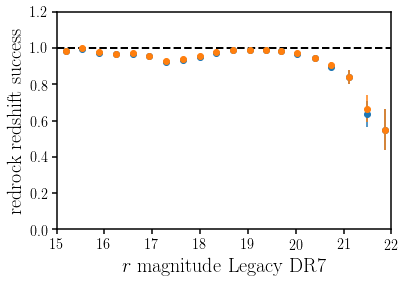

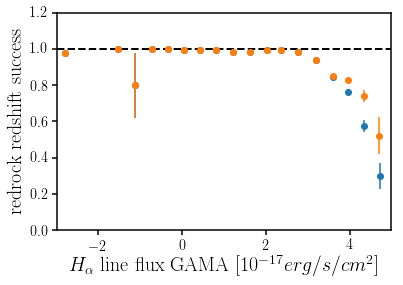

In [36]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot([15., 22.], [1., 1.], c='k', ls='--', lw=2)

mm, e1, ee1 = zsuccess_rate(blocks_r_mag, success, range=[15., 22.])
sub.errorbar(mm, e1, ee1, c='C0', fmt='o')
mm, e1, ee1 = zsuccess_rate_magnorm(blocks_r_mag, success, blocks_magnorm, range=[15., 22.])
sub.errorbar(mm, e1, ee1, c='C1', fmt='o')
#sub.errorbar(mm_bright, e1_bright, ee1_bright, fmt='.C1', label="bright sky")
sub.set_xlabel(r'$r$ magnitude Legacy DR7', fontsize=20)
sub.set_xlim([15., 22.])
sub.set_ylabel(r'redrock redshift success', fontsize=20)
sub.set_ylim([0., 1.2])
sub.legend(loc='lower right', handletextpad=0., prop={'size': 20})
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot([-3., 5.], [1., 1.], c='k', ls='--', lw=2)
mm, e1, ee1 = zsuccess_rate(np.log10(blocks_ha_lowlim), success, range=[-3., 5.])
sub.errorbar(mm, e1, ee1, c='C0', fmt='o')
mm, e1, ee1 = zsuccess_rate_magnorm(np.log10(blocks_ha_lowlim), success, blocks_magnorm, range=[-3., 5.])
sub.errorbar(mm, e1, ee1, c='C1', fmt='o')
sub.set_xlabel(r'$H_\alpha$ line flux GAMA $[10^{-17}erg/s/cm^2]$', fontsize=20)
sub.set_xlim([-3., 5.])
sub.set_ylabel(r'redrock redshift success', fontsize=20)
sub.set_ylim([0., 1.2])
sub.legend(loc='lower right', handletextpad=0., prop={'size': 20})

the `magnorm_flag` does not significantly impact the redshift success rate